# **EXPLANATION**

The given dataset consists of a small number of x-ray images. Rather than training a neural network model from scratch, the best way to learn using small amounts of data is to use transfer learning. This kind of learning method also aims to prevent the model from overfitting. Therefore, I decided to use transfer learning as weight initialization and then fine-tuned the weights on the given dataset. However, most of pretrained network models were trained on ImageNet which consists of real-world object e.g. car, flower, animal, etc. These kinds of images are very different with tooth x-ray images. So, I was searching for the right way to do transfer learning on limited x-ray images. I found the paper entitled “COVID19XrayNet: A Two‑Step Transfer Learning Model for the COVID‑19 Detecting Problem Based on a Limited Number of Chest X‑Ray Images” which proposes a fairly interesting method. This method is combined pretrained Resnet34 with Feature Smoothing Layer (FSL) and Feature Extraction Layer (FEL) to improve the classification accuracy of covid-19 lung x-ray images. I tried to adopt this approach on the given tooth dataset. I evaluated the neural network model on my own tooth test set, handpicked from google (See: [Test Set](https://drive.google.com/drive/folders/10pv5nQWQLPD3MMy4E3WXulrkyF8AZD05?usp=sharing)). Based on the experimental results, this model doesn’t perform well on the given dataset. I think this is because the amount of data used for training is far different from the data used in that paper (at least 5000 of lung x-ray images were used to train) so the FSL and FEL layers are struggle to generalize the feature. I am also compared to another well known classifier model. As shows in the chart below, the pretrained Resnet18 shows promising performance than others classifier model. So, in my opinion, using Pretrained Resnet18 to classify dental images has been pretty good so far. The conv layer used in Resnet18 is not too deep and good enough to do classifications between two classes. To improve the accuracy, I suggest to modify the residual block on Resnet18 using pre-activation residual block. In my previous research, the pre-activation model is able to increase the accuracy and faster to converge rather than the original residual block.

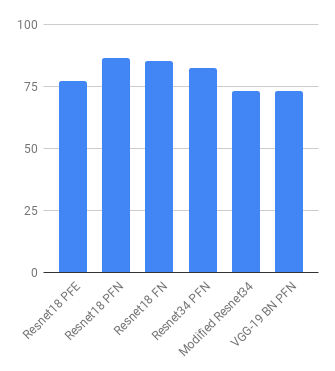


**List of Model Followed by Accuracy Score**
1. Resnet18 PFE : *pretrained, transfer learning (feature extraction)* = 77.03%
2. Resnet18 PFN : *pretrained, transfer learning (fine tune)* = 86.49%
3. Resnet18 FN : *transfer learning (fine tune)* = 85.13%
4. Resnet34 PFN : *pretrained, transfer learning (fine tune)* = 82.38%
5. Modified Resnet34 : *adopted from paper using FSL and FEL* = 72.97%
6. VGG-19 BN PFN : *pretrained, transfer learning (fine tune)* = 72.97%


In [323]:
import os
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import itertools
import numpy as np
import matplotlib.pyplot as plt
 
from PIL import Image
from math import ceil
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.datasets import ImageFolder

In [324]:
SEED = 4444
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
root_path = './drive/My Drive/Tooth/Data'

NUM_EPOCH = 300
NUM_BATCH = 0
BATCH_SIZE = 16
ITERATION = None
MODEL = models.resnet18(pretrained=True)
FINETUNE = True
COMMENT = 'Resnet18 (001, 0001)- pretrained - finetuned - AdamW'
CLASSES = {}
LR = 0.001

In [325]:
class FSL(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(FSL, self).__init__()
        self.conv = nn.Conv2d(in_feats, out_feats, 1)
        self.bn = nn.BatchNorm2d(out_feats)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [326]:
class FEL(nn.Module):
    def __init__(self, in_feats, out_feats, kernel, stride, pad):
        super(FEL, self).__init__()
        self.conv = nn.Conv2d(in_feats, out_feats, kernel_size=kernel, stride=stride, padding=pad)
        self.bn = nn.BatchNorm2d(out_feats)
        self.act = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.avgpool(x)
        return x

In [327]:
class ClassifierNet(nn.Module):
    def __init__(self):
        super(ClassifierNet, self).__init__()
        first_part = nn.ModuleList(models.resnet34(pretrained=True).children())[:5]           #return the first conv to the first residual block
        self.first_part = nn.Sequential(*first_part)
        
        self.FSL1 = FSL(64,64)
        
        second_part = nn.ModuleList(models.resnet34(pretrained=True).children())[5]           #return the second residual block
        self.second_part = nn.Sequential(*second_part)
        
        FSL2 = [FSL(128,128) for i in range(4)]                                               #using 4 blocks of FSL layer
        self.FSL2 = nn.Sequential(*FSL2)
 
        third_part = nn.ModuleList(models.resnet34(pretrained=True).children())[6]            #return the third residual block
        self.third_part = nn.Sequential(*third_part)
 
        self.FEL = FEL(256,512,3,2,1)
        self.fc = nn.Linear(512,len(CLASSES))
 
    def forward(self,x):
        x = self.first_part(x)
        x = self.FSL1(x)
        x = self.second_part(x)
        x = self.FSL2(x)
        x = self.third_part(x)
        x = self.FEL(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [328]:
def transfer_learning(net, finetune=True):
    if finetune:
        # Resnet
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, len(CLASSES))

        # VGG
        # net.classifier[6].out_features = len(CLASSES)        
    else:
        # Resnet
        for param in net.parameters():
            param.requires_grad = False
        fc_in_feats = net.fc.in_features
        net.fc = nn.Linear(fc_in_feats, len(CLASSES))

        # VGG
        # for param in net.parameters():
        #     param.requires_grad = False
        # fc_in_feats = net.classifier[6].in_features
        # net.fc = nn.Linear(fc_in_feats, len(CLASSES))
    return net

In [329]:
def train(net, loss_fn, optimizer, train_loader, epoch, log_dir):
    global ITERATION
    ITERATION = NUM_BATCH * (epoch-1) + 1
    net.train()
    train_bar = tqdm(train_loader)
    batch_sizes = 0
    total_loss  = 0
    
    for image, label in train_bar:
        batch_size = label.size(0)
        batch_sizes += batch_size

        image = image.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        prediction = net(image)

        loss = loss_fn(prediction, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        train_bar.set_description(desc='itr:%d [%3d/%3d] Loss: %.8f' %(ITERATION, epoch, NUM_EPOCH, total_loss/batch_sizes))
        write_csv(log_dir+'/loss_log.csv', [ITERATION, loss.item()])
        ITERATION = ITERATION + 1
    
    write_csv(log_dir+'/loss_log_epoch.csv', [epoch, total_loss/batch_sizes])            
    torch.cuda.empty_cache()
 
def main(checkpoint=None, batch_size=BATCH_SIZE, lr=LR):
    transform_train = transforms.Compose([
        transforms.Pad((50,0),padding_mode='reflect'),
        transforms.Resize((224,224)),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),                                  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                      
    ])

    transform_test = transforms.Compose([
        transforms.Pad((50,0),padding_mode='reflect'),
        transforms.Resize((224,224)),                                  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                      
    ])

    train_set = ImageFolder(os.path.join(root_path, 'Train'), transform_train)
    val_set = ImageFolder(os.path.join(root_path, 'Val'), transform_test)
    test_set = ImageFolder(os.path.join(root_path, 'Test'), transform_test)
    
    train_loader = DataLoader(dataset=train_set, num_workers=16, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_set, num_workers=16, batch_size=1, shuffle=False)
    test_loader = DataLoader(dataset=test_set, num_workers=16, batch_size=1, shuffle=False)
    
    global NUM_BATCH
    NUM_BATCH = ceil(len(train_loader.dataset)/batch_size)
    global CLASSES
    CLASSES = train_set.classes

    net = transfer_learning(MODEL, finetune=FINETUNE)
    # net = ClassifierNet()
    net = net.cuda()
    loss = nn.CrossEntropyLoss().cuda()
    optimizer = optim.AdamW(net.parameters(), lr=lr)

    log_dir = './drive/My Drive/Tooth/logs/' + COMMENT
    if not os.path.exists(log_dir):
        mkdir(log_dir)
    checkpoint_dir = './drive/My Drive/Tooth/checkpoint/' + COMMENT
    if not os.path.exists(checkpoint_dir):
        mkdir(checkpoint_dir)
    
    if checkpoint is not None:
        load_checkpoint(checkpoint_dir, net, optimizer, checkpoint)
        lr = get_lr(optimizer)
    else:
        checkpoint = 0

    for epoch in range(checkpoint+1, NUM_EPOCH+1):
        # if epoch % 4 == 0:
        #     lr = lr / 2.
        #     change_lr(optimizer,lr)

        if epoch > 3 :
            lr = 0.0001
            change_lr(optimizer,lr)

        train(net, loss, optimizer, train_loader, epoch, log_dir)
        save_checkpoint(checkpoint_dir, net, optimizer, epoch)
        with torch.no_grad():
            if epoch % 3 == 0 or epoch < 3:
                accuracy_val, _ = validate(net, 'val', epoch, val_loader)
                accuracy_test, _ = validate(net, 'test', epoch, test_loader)
                write_csv(log_dir + '/accuracy_validation_log.csv', [ITERATION, accuracy_val])
                write_csv(log_dir + '/accuracy_test_log.csv', [ITERATION, accuracy_test])

In [330]:
def validate(net, set_type, epoch, data_loader):
    correct = 0
    total = 0
    all_preds = torch.tensor([])	
    
    net.eval()
    for image, label in data_loader:
        image = image.cuda()
        label = label.cuda()
        
        outputs = net(image)
        _, pred = torch.max(outputs.cpu().detach().data, 1)
        all_preds = torch.cat((all_preds, outputs.cpu().detach()),dim=0)
        
        total += label.cpu().detach().size(0)
        correct += (pred == label.cpu().detach()).sum().item()
        torch.cuda.empty_cache()
    
    accuracy = 100 * correct / total
    print('Accuracy on the ' + str(total) + ' ' + set_type + ' set: {}%'.format(accuracy))
    return accuracy, all_preds

In [331]:
def test(checkpoint=1):
    transform_test = transforms.Compose([
        transforms.Pad((50,0),padding_mode='reflect'),
        transforms.Resize((224,224)),                                  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                      
    ])

    test_set = ImageFolder(os.path.join(root_path, 'Test'), transform_test)
    test_loader = DataLoader(dataset=test_set, num_workers=16, batch_size=1, shuffle=False)
    global CLASSES
    CLASSES = test_set.classes
    
    net = transfer_learning(MODEL, finetune=FINETUNE)
    net = net.cuda()

    checkpoint_dir = './drive/My Drive/Tooth/checkpoint/' + COMMENT
    load_checkpoint(checkpoint_dir, net, None, checkpoint)
    with torch.no_grad():
        _, all_preds = validate(net, 'test', checkpoint, test_loader)
    pass

    cm = confusion_matrix(test_set.targets, all_preds.argmax(dim=1))
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cm, test_set.classes)

In [332]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [333]:
def mkdir(path):
    try:
        os.mkdir(path)
    except:
        pass

def save_checkpoint(checkpoint_dir, model, optim, epoch):
    save_path = checkpoint_dir + '/epoch_{}.pth'.format(epoch)
    state = {'epoch': epoch, 'model': model, 'optim': optim}
    torch.save(state, save_path)
    print("Checkpoint saved to {}".format(save_path))

def load_checkpoint(checkpoint_dir, net, optimizer, epoch):
    load_path = checkpoint_dir + '/epoch_{}.pth'.format(epoch)
    weights = torch.load(load_path)
    net.load_state_dict(weights['model'].state_dict())
    if optimizer is not None:
        optimizer.load_state_dict(weights['optim'].state_dict())

def change_lr(optim, lr):
    for param in optim.param_groups:
        param['lr'] = lr

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def write_csv(file, data):
    with open(file, 'a', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(data)

Accuracy on the 74 test set: 86.48648648648648%
Confusion matrix, without normalization
[[36  1]
 [ 9 28]]


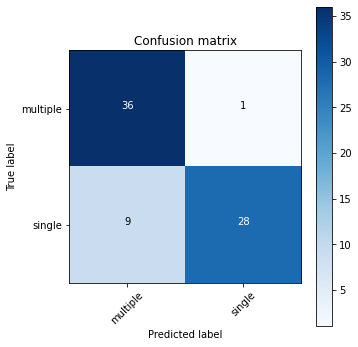

In [334]:
if __name__ == '__main__':
    # main()
    test(285)
    pass